In [1]:
#%%nbtemplate hide
# Prepare nbtemplate magics (use %%nbtemplate for jinja-assisted evaluation)
# hide option tells the runtime renderer not to render this cell
import nbtemplate
nbtemplate.init(lambda _=globals: _())

# Imputing Knowledge about Gene and Protein Function with Machine Learning

In [2]:
%matplotlib inline
# Imports
## Data processing
import pandas as pd
import numpy as np
import scipy as sp
## Machine Learning
import sklearn as sk
from sklearn import (
    calibration,
    decomposition,
    ensemble,
    feature_selection,
    linear_model,
    manifold,
    metrics,
    model_selection,
    pipeline,
    preprocessing,
    svm,
    tree,
)
## Plotting
from matplotlib import pyplot as plt
## Harmonizome API
from harmonizome import Harmonizome
## Utility
import re
import json
from functools import reduce
from IPython.display import display

In [3]:
# Utility functions

def try_json_loads(s):
    try:
        return json.loads(s)
    except:
        return ''

## Create custom "randfloat" that behaves like randint but for floats
from scipy.stats import uniform, randint
def randfloat(start, end):
    ''' Utility function for generating a float uniform distribution '''
    return uniform(start, end - start)

# reproducable random seed
rng = 2018

## Inputs

Given a target attribute of interest, we will use machine learning to predict genes that are strongly correlated with that target. Using the Harmonizome data query API, we download the dataset containing the target attribute as well as a number of well-populated Omics datasets for more genes and features and build a large sparse dataframe.

In [73]:
%%nbtemplate
{{ SectionField(
    title='ATTRIBUTE AND PREDICTION CLASS DATASET SELECTION',
    subtitle='Select the datasets to use for learning and classification.',
    group='DATASETS',
) }}
attribute_datasets = {{ MultiChoiceField(
    name='attribute_datasets',
    label='Attribute Selection (place cursor inside the box to add more datasets)',
    hint='Databases to use for prediction',
    description='The selected datasets will be concatenated and used to train the model.',
    default=[
        'CCLE Cell Line Gene Expression Profiles',
        'ENCODE Transcription Factor Targets',
    ],
    value=[
        'CCLE Cell Line Gene Expression Profiles',
        'ENCODE Transcription Factor Targets',
        'Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles',
        'CHEA Transcription Factor Targets',
        'BioGPS Cell Line Gene Expression Profiles',
        'GTEx Tissue Gene Expression Profiles',
    ],
    choices=[
        'CCLE Cell Line Gene Expression Profiles',
        'ENCODE Transcription Factor Targets',
        'Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles',
        'CHEA Transcription Factor Targets',
        'BioGPS Cell Line Gene Expression Profiles',
        'GTEx Tissue Gene Expression Profiles',
    ],
    group='DATASETS',
) }}
target = "{{ TargetClassSearchField(
    name='target',
    label='Target Selection',
    hint='Class or Gene you want to predict',
    default='integumentary system cancer (Class from DISEASES Text-mining Gene-Disease Assocation Evidence Scores)',
    value='LRFN4 (Gene from DISEASES Text-mining Gene-Disease Assocation Evidence Scores)',
    hints=[
        'cancer',
        'lung',
        'heart',
        'tumor',
    ],
    group='DATASETS',
) }}"

Select Omics datasets are downloaded and joined on the Gene producing a large association matrix. Only association is preserved in order to create a binary classification task.

In [76]:
# Download attribute datasets from Harmonizome
df_attributes = list(Harmonizome.download_df(
    [dataset
     for dataset in attribute_datasets],
    ['gene_attribute_matrix.txt.gz'],
))
for name, df in zip(attribute_datasets, df_attributes):
    df.index.name = json.loads(df.index.name)[0]
    df.index = df.index.map(lambda s: json.loads(s)[0])
    df.columns = df.columns.map(lambda s: ' '.join(ss for ss in try_json_loads(s) if ss != 'na'))
    print('%s shape:' % (name), df.shape)
    display(df.head())

# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='outer', # Keep mis-matched index
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]

X = df.applymap(lambda f: 1 if f!=0 else 0)
print('Total Shape:', X.shape)
display(X.head())

CCLE Cell Line Gene Expression Profiles shape: (18025, 1037)


,CHL1 skin,HMCB skin,HS852T skin,HS695T skin,A101D skin,HS294T skin,SNU466 central nervous system,SKMEL31 skin,SKMEL24 skin,WM115 skin,...,HEL9217 haematopoietic and lymphoid tissue,HEL haematopoietic and lymphoid tissue,UT7 haematopoietic and lymphoid tissue,SET2 haematopoietic and lymphoid tissue,MOLM16 haematopoietic and lymphoid tissue,KU812 haematopoietic and lymphoid tissue,TF1 haematopoietic and lymphoid tissue,MEG01 haematopoietic and lymphoid tissue,KYO1 haematopoietic and lymphoid tissue,K562 haematopoietic and lymphoid tissue
GeneSym,,,,,,,,,,,,,,,,,,,,,
FBN1,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
ITGBL1,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
LRP1,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
LTBP2,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
PARVA,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


ENCODE Transcription Factor Targets shape: (22819, 181)


,ARID3A 1820,ATF1 466,ATF2 1386,ATF3 467,BACH1 571,BATF 10538,BCL11A 53335,BCL3 602,BCLAF1 9774,BDP1 55814,...,ZC3H11A 9877,ZEB1 6935,ZKSCAN1 7586,ZMIZ1 57178,ZNF143 7702,ZNF217 7764,ZNF263 10127,ZNF274 10782,ZNF384 171017,ZZZ3 26009
GeneSym,,,,,,,,,,,,,,,,,,,,,
A1BG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles shape: (17979, 414)


,"VIIB, left, lateral hemisphere 4741","VIIIA, left, lateral hemisphere 4742","Crus I, left, lateral hemisphere 4739","Crus II, left, lateral hemisphere 4740","Crus II, left, paravermis 4724","Crus I, left, paravermis 4723","VI, left, paravermis 4722","V, left, paravermis 4720","VIIB, left, paravermis 4725","VIIIA, left, paravermis 4726",...,"lateral group of nuclei, right, ventral division 4472","lateral group of nuclei, right, dorsal division 4464","anterior group of nuclei, right 4450","medial group of nuclei, right 4455","rostral group of intralaminar nuclei, right 4487","posterior group of nuclei, right 4483","dorsal lateral geniculate nucleus, left 4440","dorsal lateral geniculate nucleus, right 4495","caudal group of intralaminar nuclei, left 4437","caudal group of intralaminar nuclei, right 4492"
GeneSym,,,,,,,,,,,,,,,,,,,,,
CREG2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RGS4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM81A,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01098,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BRINP2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CHEA Transcription Factor Targets shape: (21585, 199)


,KLF2 10365,KLF5 688,AHR 196,ARNT 405,ZNF217 7764,PAX3 5077,CEBPD 1052,NFE2L2 4780,AP1S2 8905,ETS1 2113,...,IKZF1 10320,ZNF263 10127,ZNF652 22834,TCF21 6943,E2F7 144455,BCL11B 64919,GLI1 2735,HOXA2 3199,CIITA 4261,BP1 474256
GeneSym,,,,,,,,,,,,,,,,,,,,,
MLNR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MRGPRG-AS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTY3B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ST7-AS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIR632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


BioGPS Cell Line Gene Expression Profiles shape: (12628, 108)


,U118,,U87,,U138,,A172,,LN18,,...,LNCAP,huh-7,,HEPG2,HEK293,,HEK 293 T-rex,,HEK 293T,
GeneSym,,,,,,,,,,,,,,,,,,,,,
TLL1,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GYPA,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PF4V1,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF674,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LPAR4,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


GTEx Tissue Gene Expression Profiles shape: (25564, 29)


,heart,muscle,pancreas,liver,adipose tissue,breast,nerve,blood vessel,ovary,uterus,...,brain,pituitary,adrenal gland,lung,blood,spleen,colon,small intestine,stomach,kidney
GeneSym,,,,,,,,,,,,,,,,,,,,,
RPS2P5,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RPL7AP30,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RPS5,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RPS2P46,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOA1,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Shape: (29484, 1968)


,CHL1 skin,HMCB skin,HS852T skin,HS695T skin,A101D skin,HS294T skin,SNU466 central nervous system,SKMEL31 skin,SKMEL24 skin,WM115 skin,...,brain,pituitary,adrenal gland,lung,blood,spleen,colon,small intestine,stomach,kidney
GeneSym,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
A1BG-AS1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
A2M,0,0,1,0,0,0,0,1,1,0,...,0,0,0,1,1,0,0,0,0,0
A2M-AS1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,0


We download the dataset containtaining the target.

In [77]:
# Separate target attribute and dataset
target_name, target_type, target_dataset = re.match(
    r'^(.+) \((.+) from (.+)\)$',
    target,
).groups()
target_datasets = [target_dataset]

# Download attribute datasets from Harmonizome
df_targets = list(Harmonizome.download_df(
    [dataset
     for dataset in target_datasets],
    ['gene_attribute_matrix.txt.gz'],
))

for name, df in zip(target_datasets, df_targets):
    df.index.name = json.loads(df.index.name)[0]
    df.index = df.index.map(lambda s: json.loads(s)[0])
    df.columns = df.columns.map(lambda s: ' '.join(ss for ss in try_json_loads(s) if ss != 'na'))
    print('%s shape:' % (name), df.shape)
    display(df.head())

# Assemble all target datasets
if len(df_targets) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='outer', # Keep mis-matched index
        ),
        df_targets,
    )
else:
    df = df_targets[0]

Y = df.applymap(lambda f: 1 if f!=0 else 0)
print('Total Shape:', Y.shape)
display(Y.head())

DISEASES Text-mining Gene-Disease Assocation Evidence Scores shape: (15309, 4628)


,integumentary system cancer DOID:0060122,skin cancer DOID:4159,skin carcinoma DOID:3451,basal cell carcinoma DOID:2513,keratoacanthoma DOID:3149,skin squamous cell carcinoma DOID:3151,actinic keratosis DOID:8866,seborrheic keratosis DOID:6498,verrucous carcinoma DOID:3737,infiltrative basal cell carcinoma DOID:4299,...,alternating exotropia DOID:1142,masters-allen syndrome DOID:14133,charcot-marie-tooth disease type 4 DOID:0050541,anal margin carcinoma DOID:4284,poland syndrome DOID:12961,cortical deafness DOID:0060140,form agnosia DOID:0060142,breast lipoma DOID:10199,queensland tick typhus DOID:10784,fatal infantile encephalocardiomyopathy DOID:0050713
GeneSym,,,,,,,,,,,,,,,,,,,,,
LRRTM4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LRFN4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMPA2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM174B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Shape: (15309, 4628)


,integumentary system cancer DOID:0060122,skin cancer DOID:4159,skin carcinoma DOID:3451,basal cell carcinoma DOID:2513,keratoacanthoma DOID:3149,skin squamous cell carcinoma DOID:3151,actinic keratosis DOID:8866,seborrheic keratosis DOID:6498,verrucous carcinoma DOID:3737,infiltrative basal cell carcinoma DOID:4299,...,alternating exotropia DOID:1142,masters-allen syndrome DOID:14133,charcot-marie-tooth disease type 4 DOID:0050541,anal margin carcinoma DOID:4284,poland syndrome DOID:12961,cortical deafness DOID:0060140,form agnosia DOID:0060142,breast lipoma DOID:10199,queensland tick typhus DOID:10784,fatal infantile encephalocardiomyopathy DOID:0050713
GeneSym,,,,,,,,,,,,,,,,,,,,,
LRRTM4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZNF507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LRFN4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IMPA2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM174B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
# Transpose data if we're given a gene instead of a class
if target_type == 'Gene':
    X = X.T
    Y = Y.T

# Collect genes of interest
targets = Y[Y[target_name] == 1].index
print('Number of Targets:', len(targets))

# Create final output array
y = np.in1d(X.index, targets).astype(np.int8)
print('Known Targets: %d (%0.3f %%)' % (y.sum(), 100*y.sum()/len(y)))

Number of Targets: 9
Known Targets: 0 (0.000 %)


In [82]:
targets

Index(['disease DOID:4', 'cognitive disorder DOID:1561',
       'psychotic disorder DOID:2468', 'schizophrenia DOID:5419',
       'developmental disorder of mental health DOID:0060037',
       'disease of mental health DOID:150',
       'autism spectrum disorder DOID:0060041',
       'pervasive developmental disorder DOID:0060040',
       'autistic disorder DOID:12849'],
      dtype='object')

In [72]:
df.loc['EVL'].sum()

58.0

We produce a target array containing 1 if the gene is associated and 0 otherwise.

In [51]:
# Output data shapes
print('Input shape:', X.shape)
print('Target shape:', y.shape)

Input shape: (1968, 29483)
Target shape: (1968,)


%%nbtemplate
## Dimensionality Reduction

We reduce the dimensionality of our omics feature space with {{ clf_dimensionality_reduction.value }}.

In [52]:
%%nbtemplate
{{ SectionField(
    title='SETTINGS',
    subtitle='From here you can select the various available Machine Learning algorithms, their unique settings, and the methods to use to evaluate the classifier.',
    group='SETTINGS',
) }}
clf_dimensionality_reduction = {{ ChoiceField(
    name='clf_dimensionality_reduction',
    label='Dimensionality Reduction Algorithm',
    description='A dimensionality reduction algorithm should be selected to improve the quality of the classifier.',
    default='PCA',
    choices={
        'PCA': 'sk.decomposition.PCA(n_components=64)',
        'TruncatedSVD': 'sk.decomposition.TruncatedSVD(n_components=64)',
        'IncrementalPCA': 'sk.decomposition.IncrementalPCA(n_components=64)',
        'ICA': 'sk.decomposition.FastICA(n_components=64)',
        'SparsePCA': 'sk.decomposition.SparsePCA(n_components=64)',
    },
    group='SETTINGS'
) }}

In [53]:
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)
if hasattr(clf_dimensionality_reduction, 'explained_variance_'):
    print('Explained variance:', np.sum(clf_dimensionality_reduction.explained_variance_))

Explained variance: 2444.736390438508


Explained variance: 2444.654300021875


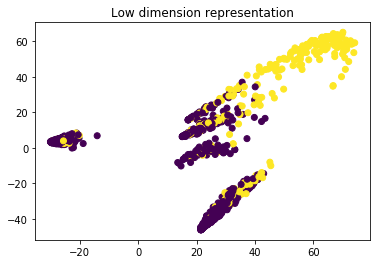

In [54]:
%%nbtemplate hide
{% if tsne %}
# Perform TSNE for low dimensional visualization
tsne = sk.manifold.TSNE(n_components=2, random_state=rng)
X_transformed = tsne.fit_transform(X_reduced, y)
plt.scatter(
   X_transformed_tsne[:, 0],
   X_transformed_tsne[:, 1],
   c=y,
)
{% else %}
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)
if hasattr(clf_dimensionality_reduction, 'explained_variance_'):
    print('Explained variance:', np.sum(clf_dimensionality_reduction.explained_variance_))

plt.title('Low dimension representation')
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
)
plt.show()
{% endif %}

%%nbtemplate
## Machine Learning
{#
We apply a {{ hyper_param_search.value }} search for the hyper parameters of a sklearn pipeline with a dimensionality reduction step of {{ clf_dimensionality_reduction.value }} and a {{ algorithm.value }} classifier using {{ cross_validation_n_folds.value }}-fold repeated stratified cross-validation, optimizing {{ primary_metric.value }}{% if evaluation_metrics.value %} and computing {{ evaluation_metrics.value.join(', ') }}{% endif %}.
#}

In [55]:
%%nbtemplate
feature_selection = {{ ChoiceField(
    name='feature_selection',
    label='Machine Learning Feature Selection',
    default='SelectFromLinearSVC',
    choices={
        'SelectFromLinearSVC': 'sk.feature_selection.SelectFromModel(sk.svm.LinearSVC(loss="squared_hinge", penalty="l1", dual=False))',
        'SelectFromExtraTrees': 'sk.feature_selection.SelectFromModel(sk.tree.ExtraTreesClassifier())',
        'SelectKBest': 'sk.feature_selection.SelectKBest("f_classif")',
        'SelectKBestChi2': 'sk.feature_selection.SelectKBest("chi2")',
        'SelectKBestMultiInfo': 'sk.feature_selection.SelectKBest("mutual_info_classif")',
    },
    group='SETTINGS'
) }}
cv_algorithm = {{ ChoiceField(
    name='cv_algorithm',
    label='Cross Validation Algorithm',
    default='StratifiedKFold',
    choices={
        'KFold': 'sk.model_selection.KFold',
        'GroupKFold': 'sk.model_selection.GroupKFold',
        'RepeatedKFold': 'sk.model_selection.RepeatedKFold',
        'StratifiedKFold': 'sk.model_selection.StratifiedKFold',
        'RepeatedStratifiedKFold': 'sk.model_selection.RepeatedStratifiedKFold',
    },
    group='SETTINGS',
) }}
algorithm = {{ ChoiceField(
    name='algorithm',
    label='Machine Learning Algorithm',
    default='RandomForestClassifier',
    description='A machine learning algorithm should be selected to construct the predictive model.',
    choices={
        'GradientBoostingClassifier': 'sk.ensemble.GradientBoostingClassifier()',
        'RandomForestClassifier': 'sk.ensemble.RandomForestClassifier()',
        'AdaBoostClassifier': 'sk.ensemble.AdaBoostClassifier()',
        'ExtraTreesClassifier': 'sk.tree.ExtraTreesClassifier()',
        'DecisionTreeClassifier': 'sk.tree.DecisionTreeClassifier()',
        'KNeighborsClassifier': 'sk.neighbors.KNeighborsClassifier()',
        'RadiusNeighborsClassifier': 'sk.neighbors.RadiusNeighborsClassifier()',
        'MLPClassifier': 'sk.neural_network.MLPClassifier()',
        'OneClassSVM': 'sk.svm.OneClassSVM()',
    },
    group='SETTINGS'
) }}
hyper_param_search = {{ ChoiceField(
    name='hyper_param_search',
    label='Hyper Parameter Search Type',
    default='RandomizedSearchCV',
    description='Hyper parameter searching is used to automatically select the best parameters (using the primary metric as the criteria).',
    choices={
        'RandomizedSearchCV': 'sk.model_selection.RandomizedSearchCV',
        'GridSearchCV': 'sk.model_selection.GridSearchCV',
    },
    group='SETTINGS'
) }}
cross_validation_n_folds = {{ IntField(
    name='cross_validation_n_folds',
    label='Cross-Validated Folds',
    description='Cross validation is employed as a strategy to train the model on data that the model has not seen before, more folds will ensure that the model is generalizing well.',
    default=3,
    min=2,
    max=10,
    group='SETTINGS'
) }}
primary_metric = "{{ ChoiceField(
    name='primary_metric',
    label='Primary Evaluation Metric',
    default='roc_auc',
    description='The primary evaluation metric is used for deciding how we assess the performance of our model.',
    choices=[
        'explained_variance',
        'r2',
        'neg_median_absolute_error',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'median_absolute_error',
        'mean_absolute_error',
        'mean_squared_error',
        'accuracy',
        'roc_auc',
        'average_precision',
        'log_loss',
        'neg_log_loss',
        'adjusted_rand_score',
        'homogeneity_score',
        'completeness_score',
        'v_measure_score',
        'mutual_info_score',
        'adjusted_mutual_info_score',
        'normalized_mutual_info_score',
        'fowlkes_mallows_score',
        'precision',
        'precision_macro',
        'precision_micro',
        'precision_samples',
        'precision_weighted',
        'recall',
        'recall_macro',
        'recall_micro',
        'recall_samples',
        'recall_weighted',
        'f1',
        'f1_macro',
        'f1_micro',
        'f1_samples',
        'f1_weighted'
    ],
    group='SETTINGS'
) }}"
evaluation_metrics = {{ MultiChoiceField(
    name='evaluation_metrics',
    label='Evaluation Metrics',
    default=[],
    description='Additional evaluation metrics can be specified, these metrics will also be reported for all models trained.',
    choices=[
        'explained_variance',
        'r2',
        'neg_median_absolute_error',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'median_absolute_error',
        'mean_absolute_error',
        'mean_squared_error',
        'accuracy',
        'roc_auc',
        'average_precision',
        'log_loss',
        'neg_log_loss',
        'adjusted_rand_score',
        'homogeneity_score',
        'completeness_score',
        'v_measure_score',
        'mutual_info_score',
        'adjusted_mutual_info_score',
        'normalized_mutual_info_score',
        'fowlkes_mallows_score',
        'precision',
        'precision_macro',
        'precision_micro',
        'precision_samples',
        'precision_weighted',
        'recall',
        'recall_macro',
        'recall_micro',
        'recall_samples',
        'recall_weighted',
        'f1',
        'f1_macro',
        'f1_micro',
        'f1_samples',
        'f1_weighted'
    ],
    group='SETTINGS',
) }}

In [56]:
%%nbtemplate
{% if algorithm.value == 'GradientBoostingClassifier' %}
## Early stopping function
def early_stopping(n_rounds, tol=0.001):
    def early_stopping_func(i, self, local):
        rounds = getattr(self, '__rounds', 0)
        last = getattr(self, '__last', None)
        current = self.train_score_[i]
        if last and current and abs(current - last) < tol:
            rounds += 1
            if rounds > n_rounds:
                return True
        else:
            rounds = 0
        setattr(self, '__last', current)
        setattr(self, '__rounds', rounds)
        return False
    return early_stopping_func
{% endif %}

In [57]:
%%nbtemplate hide
{#
param_grid = {
    'reduce_dim__n_components': randint(2, 1024),
{% if algorithm.value == 'GradientBoostingClassifier' %}
    'clf__loss': ['deviance', 'exponential'],
    'clf__learning_rate': randfloat(0.001, 1.),
    'clf__subsample': randfloat(0.01, 1.),
{% elif algorithm.value == 'RandomForestClassifier' %}
    'clf__oob_score': [True],
    'clf__criterion': ['gini', 'entropy'],
{% endif %}
    'clf__n_estimators': randint(10, 200),
    'clf__max_depth': randint(20, 50),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_impurity_decrease': randfloat(0., 0.2),
    'clf__min_weight_fraction_leaf': randfloat(0., 0.5),
}

fit_params = {
{% if algorithm.value == 'GradientBoostingClassifier' %}
    'clf__monitor': early_stopping(5),
{% endif %}
}
#}

In [58]:
cv = cv_algorithm(
    n_splits=cross_validation_n_folds,
    shuffle=True,
    random_state=rng,
)

model = sk.calibration.CalibratedClassifierCV(
    sk.pipeline.Pipeline([
        ('reduce_dim', clf_dimensionality_reduction),
        ('feature_selection', feature_selection),
        ('clf', algorithm),
    ]),
    cv=cv,
)

# Scoring parameters
scoring_params = {k: v
                  for k,v in metrics.scorer.SCORERS.items()
                  if k == primary_metric or k in evaluation_metrics}

This visualization shows illustrates the cross-validated performance of the model. Low fold variance and high AUC is desired in a well-generalized model.

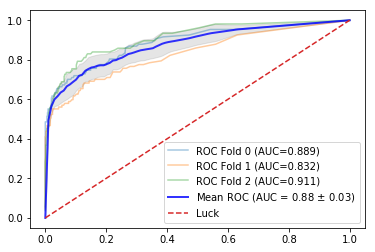

In [59]:
fig, ax = plt.subplots()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    y_proba = model.predict_proba(X.values[test]) # Probability prediction will be True
    fpr, tpr, _ = sk.metrics.roc_curve(y[test], y_proba[:, 1])
    tprs.append(sp.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = sk.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, alpha=0.4, label='ROC Fold %d (AUC=%0.3f)' % (fold, roc_auc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sk.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

ax.plot([0,1],[0,1],'--', label='Luck')
ax.legend()

In [60]:
z = (mean_auc - 0.5)/std_auc
cl = sp.stats.norm.cdf(z) * 100
ci = sp.stats.norm.interval(0.95, loc=mean_auc, scale=std_auc)
print('Confidence interval (95%)', ci)
print("We are %0.3f %% confident the model's results are not just chance." % (cl))
if cl > 95:
    print('This is statistically significant. These results can be trusted.')
else:
    print('This is not statistically significant. These results should not be trusted.')

Confidence interval (95%) (0.8099703911302394, 0.940473947297056)
We are 100.000 % confident the model's results are not just chance.
This is statistically significant. These results can be trusted.


This will take a long time as we are evaluating n_iter different models n_splits different times each computing all the metrics on `product(X.shape)` data points--not to mention the size of each model dictated by the range of parameters specified in the params dict.

In [61]:
cm = metrics.confusion_matrix(y, model.predict(X.values))
display(cm)
print('\n',
    'True labels predicted to be true:', cm[0,0], '\n',
    'True labels predicted to be false:', cm[0,1], '\n',
    'False labels predicted to be true:', cm[1,0], '\n',
    'False labels predicted to be false:', cm[1,1])

array([[1642,    6],
       [  76,  244]])


 True labels predicted to be true: 1642 
 True labels predicted to be false: 6 
 False labels predicted to be true: 76 
 False labels predicted to be false: 244


In [62]:
# Obtain prediction results
y_preds = model.predict(X)
y_probas = model.predict_proba(X)[:, 1]
results = pd.DataFrame(np.array([
    y,
    y_preds,
    y_probas,
]).T, columns=[
    'Known',
    'Predicted',
    'Prediction Probability',
], index=X.index)
results[((results['Known'] != results['Predicted']) & (results['Prediction Probability'] > 0.5))]

,Known,Predicted,Prediction Probability
FLI1 2313 (ENCODE Transcription Factor Targets),0.0,1.0,0.598231
GATA2 2624 (ENCODE Transcription Factor Targets),0.0,1.0,0.930611
THAP1 55145 (ENCODE Transcription Factor Targets),0.0,1.0,0.767568
"anterior hypothalamic area, right 4629 (Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles)",0.0,1.0,0.575304
"paraventricular nucleus of the hypothalamus, right 4604 (Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles)",0.0,1.0,0.598231
RS11846 (BioGPS Cell Line Gene Expression Profiles),0.0,1.0,0.683434


In [63]:
%%nbtemplate hide
{{ SectionField(
    title='LAUNCH',
    subtitle='Loading...',
    group='LAUNCH',
) }}